# Postprocess neutral ABL case

In [1]:
%%capture 
import sys, os, shutil
postproamrwinddir = '~/src/amr-wind-frontend/'
if postproamrwinddir not in sys.path:
    sys.path.append(postproamrwinddir)
# Load the libraries
import matplotlib.pyplot as plt
#import amrwind_frontend  as amrwind
import postproamrwindabl as ppabl
import numpy             as np
from matplotlib import cm
import re
import time
import pandas as pd
import xarray as xr

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
def plotrotorlines(zhh, rotorD, xstart, xend, **kwargs):
    plt.hlines(zhh,             xstart, xend, linewidth=1.0, **kwargs) # Plot the HH line
    plt.hlines(zhh+rotorD*0.5,  xstart, xend, linewidth=0.5, **kwargs) # Plot the HH line
    plt.hlines(zhh-rotorD*0.5,  xstart, xend, linewidth=0.5, **kwargs) # Plot the HH line    
    
def savecsvdata(d, savekeys, filename):
    # Create a new dictionary
    dfcsv = pd.DataFrame()
    for newkey,oldkey in savekeys.items():
        dfcsv[newkey] = d[oldkey]
    dfcsv.to_csv(filename,index=False,sep=',')
    return

def plot_profile(var,df,avgt):
    returndict = {}
    temp_dict = {}
    prof = ppabl.CalculatedProfile.fromdict(ppabl.statsprofiles[var],df,temp_dict,avgt=avgt)
    z, plotdat = prof.calculate()
    returndict[ppabl.statsprofiles[var]['header']] = {'z':z, 'data':plotdat}
    return returndict 

In [3]:
rundir='/nscratch/gyalla/HFM/exawind-benchmarks/amr-wind/atmospheric_boundary_layer/neutral/runs/'
resultsdir='../results/'
casenames = [
  'Neutral ABL, Grid C',
  'Neutral ABL, Grid D',
]
caseparams = {}
caseparams[casenames[0]] = {'rundir':rundir + '/C_grid', 'tag':'Neutral ABL - Grid C', 'saveprefix':'avgprofile_C','ncfile':'abl_statistics240000.nc', 'avgtimes':[120000,125000],'lstyle':{'color':'tab:blue',}}
caseparams[casenames[1]] = {'rundir':rundir + '/D_grid', 'tag':'Neutral ABL - Grid D', 'saveprefix':'avgprofile_D','ncfile':'post_processing/abl_statistics480000.nc', 'avgtimes':[120000,125000],'lstyle':{'color':'tab:orange',}}

# Hub-height locations
plotheights=[90]
zHH_target    = 90.0
rotorD        = 126
bottom_tip    = zHH_target - 0.5*rotorD
top_tip       = zHH_target + 0.5*rotorD
# Load the entire netcdf in memory
loadinmemory = False   # Do this only if there's enough RAM and for new (python 3+ netCDF4) libraries

In [4]:
dfs = {}
for case in casenames:
    print("Case: ",case)
    file = caseparams[case]['rundir'] + '/' + caseparams[case]['ncfile']
    df = ppabl.loadnetcdffile(caseparams[case]['rundir']+'/'+caseparams[case]['ncfile'], usemmap=loadinmemory)
    report = ppabl.printReport(df,avgt=caseparams[case]['avgtimes'], heights=plotheights,span=(bottom_tip,top_tip))
    dfs[case] = {}
    dfs[case]['df'] = df
    dfs[case]['report'] = report

Case:  Neutral ABL, Grid C
Loading w'theta'_r
Loading theta
Loading u'u'_r
Loading w'w'_r
Loading v
Loading v'v'_r
Loading u
        z       Uhoriz      WindDir       TI_TKE     TI_horiz        Alpha    Alpha-Fit     ObukhovL         Veer     Veer-Fit 
      ===         ====         ====         ====         ====         ====         ====         ====         ====         ==== 
    90.00 4.391980e+00 2.527041e+02 6.034973e-02 9.263573e-02 1.465347e-01 1.459290e-01 7.298625e+03 2.418350e-02 2.371547e-02 

ustar: 0.208411
zi: 352.066531
Case:  Neutral ABL, Grid D
Loading w'theta'_r
Loading theta
Loading u'u'_r
Loading w'w'_r
Loading v
Loading v'v'_r
Loading u
        z       Uhoriz      WindDir       TI_TKE     TI_horiz        Alpha    Alpha-Fit     ObukhovL         Veer     Veer-Fit 
      ===         ====         ====         ====         ====         ====         ====         ====         ====         ==== 
    90.00 4.364165e+00 2.521579e+02 6.034343e-02 9.273637e-02 1.747254e-01 1.6

## Plot velocity profile

Loading u
Loading v
Loading u
Loading v


Text(0, 0.5, '$z/z_i$ [-]')

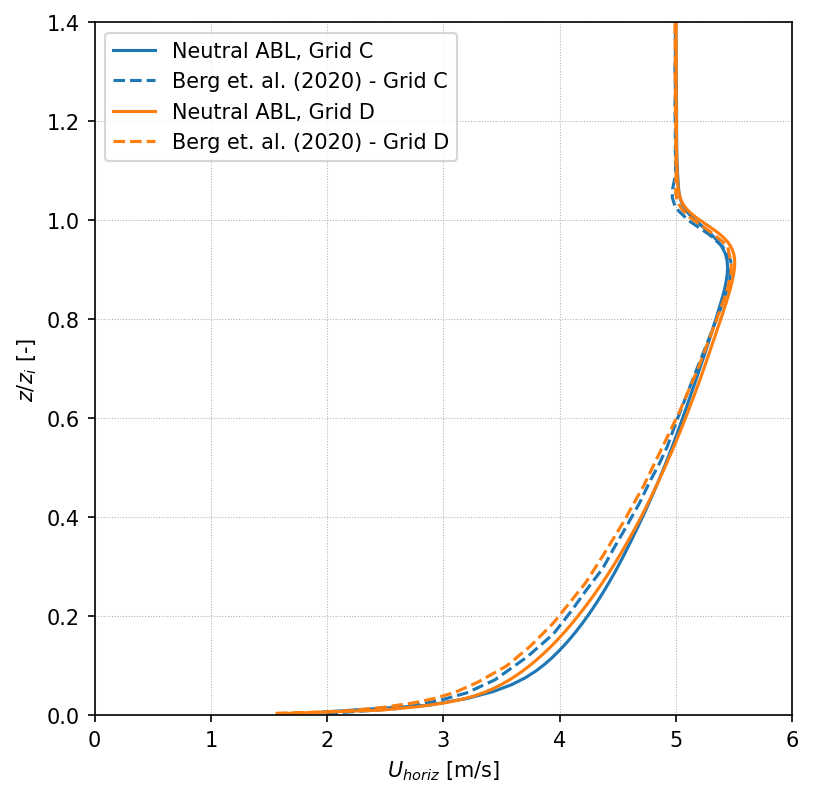

In [5]:
# Plot velocity
var='Uhoriz'
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
csvfiles = {}
csvfiles[casenames[0]] = ('../results/S_C_berg.csv','Berg et. al. (2020) - Grid C')
csvfiles[casenames[1]] = ('../results/S_D_berg.csv','Berg et. al. (2020) - Grid D')
for case in casenames:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color=lstyle['color'],ls='--',label=csvfiles[case][1])

ax.legend()
ax.set_xlim([0, 6])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$U_{horiz}$ [m/s]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')

## Plot temperature profiles

Loading theta
Loading theta


Text(0, 0.5, '$z/z_i$ [-]')

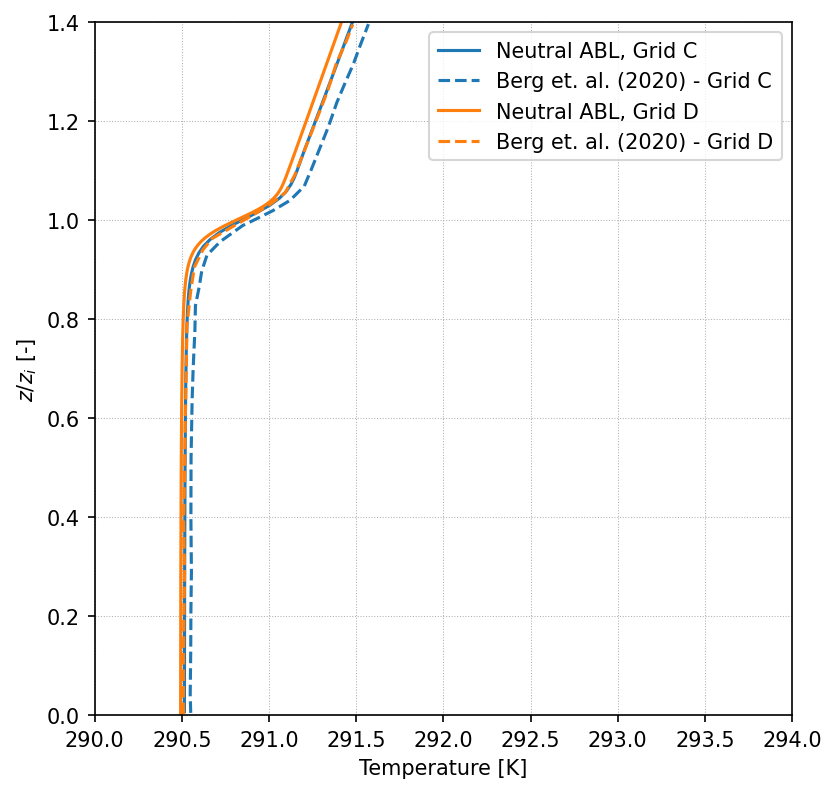

In [6]:
var = ('Temperature','T')
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
csvfiles = {}
csvfiles[casenames[0]] = ('../results/T_C_berg.csv','Berg et. al. (2020) - Grid C')
csvfiles[casenames[1]] = ('../results/T_D_berg.csv','Berg et. al. (2020) - Grid D')
for case in casenames:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var[0],df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var[1]]['data'], amrdat[var[1]]['z']/report['zi'], label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color=lstyle['color'],ls='--',label=csvfiles[case][1])


ax.legend()
ax.set_xlim([290, 294])
ax.set_ylim([0, 1.4])
ax.set_xlabel(var[0] + ' [K]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')

## Plot veer profile

Loading u
Loading v
Loading u
Loading v


Text(0, 0.5, '$z/z_i$ [-]')

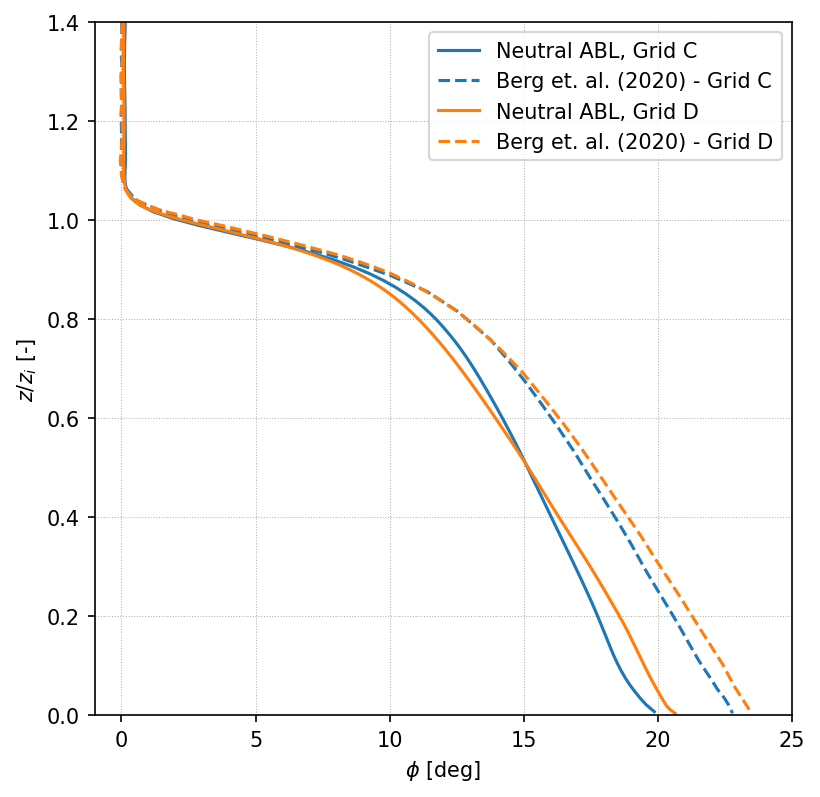

In [7]:
var='WindDir'
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
csvfiles = {}
csvfiles[casenames[0]] = ('../results/phi_C_berg.csv','Berg et. al. (2020) - Grid C')
csvfiles[casenames[1]] = ('../results/phi_D_berg.csv','Berg et. al. (2020) - Grid D')
for case in casenames:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(270-amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color=lstyle['color'],ls='--',label=csvfiles[case][1])

ax.legend()
ax.set_xlim([-1, 25])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$\phi$ [deg]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')


## Plot TI

Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r


Text(0, 0.5, '$z/z_i$ [-]')

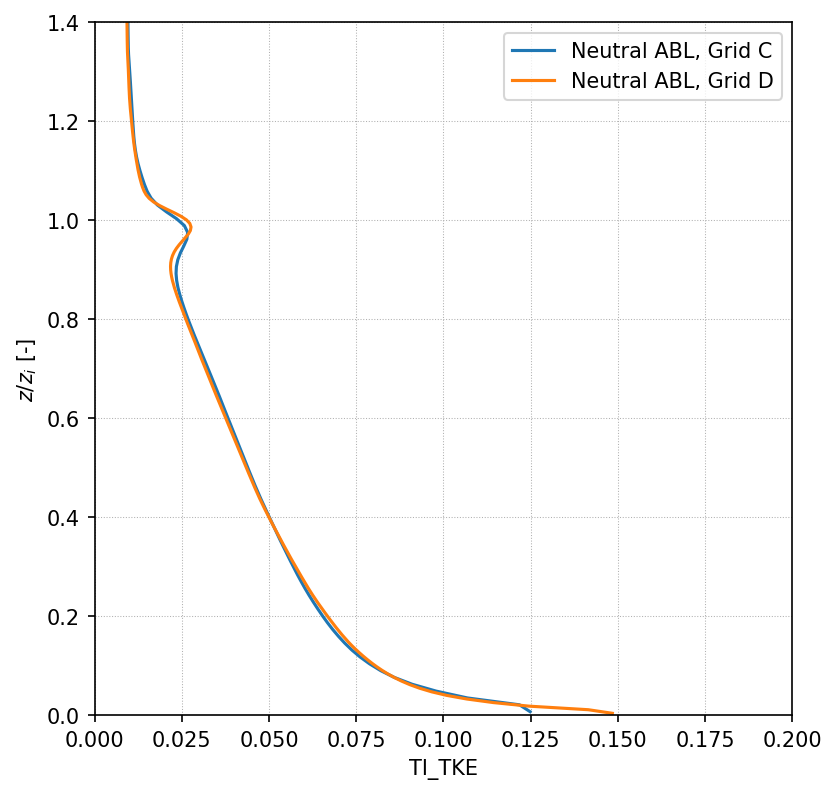

In [8]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
var = 'TI_TKE'
for case in casenames:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)
ax.legend()
ax.set_xlim([0, 0.2])
ax.set_ylim([0, 1.4])
ax.set_xlabel('TI_TKE')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')

### Plot Wind Shear 

Loading u
Loading v
Loading u
Loading v


Text(0, 0.5, '$z/z_i$ [-]')

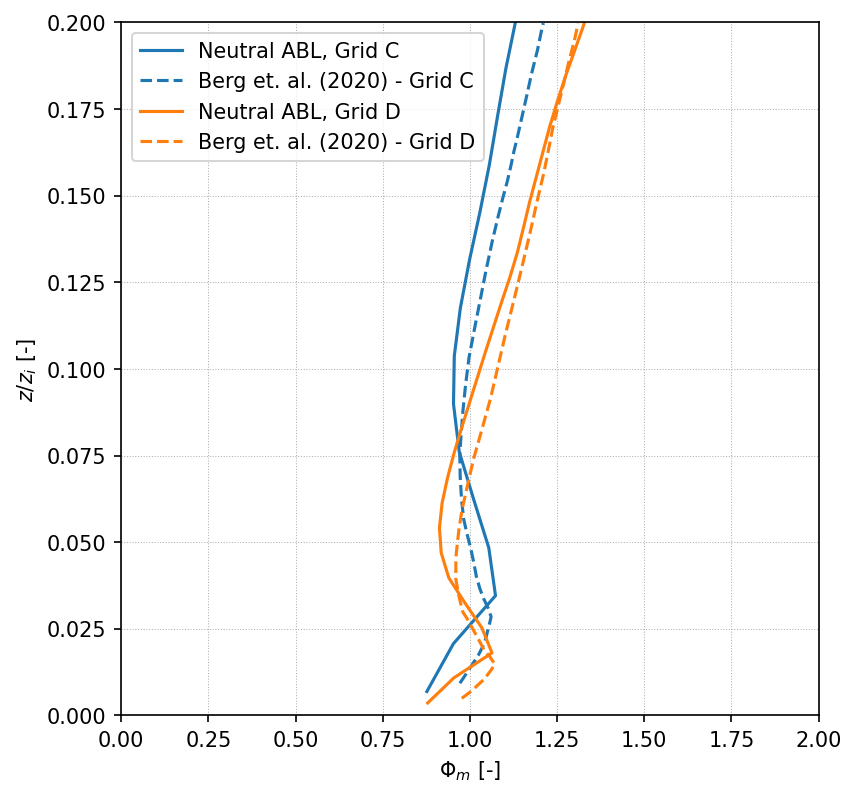

In [9]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
csvfiles = {}
csvfiles[casenames[0]] = ('../results/PHI_M_C_berg.csv','Berg et. al. (2020) - Grid C')
csvfiles[casenames[1]] = ('../results/PHI_M_D_berg.csv','Berg et. al. (2020) - Grid D')
for case in casenames:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile('Uhoriz',df,caseparams[case]['avgtimes'])
    S = amrdat['Uhoriz']['data']
    z = amrdat['Uhoriz']['z'][:-1]
    dSdZ = np.diff(S)/(z[1]-z[0])
    kappa = 0.4
    ustar = report['ustar']
    zi = report['zi']
    phi_m = (kappa*z/report['ustar'])*dSdZ
    lstyle=caseparams[case]['lstyle']
    plt.plot(phi_m, z/zi, label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color=lstyle['color'],ls='--',label=csvfiles[case][1])


ax.legend()
ax.set_xlim([0.0, 2.0])
ax.set_ylim([0, 0.2])
ax.set_xlabel('$\Phi_m$ [-]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')

### Plot Reynolds Stress

Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r
Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r


Text(0, 0.5, '$z/z_i$ [-]')

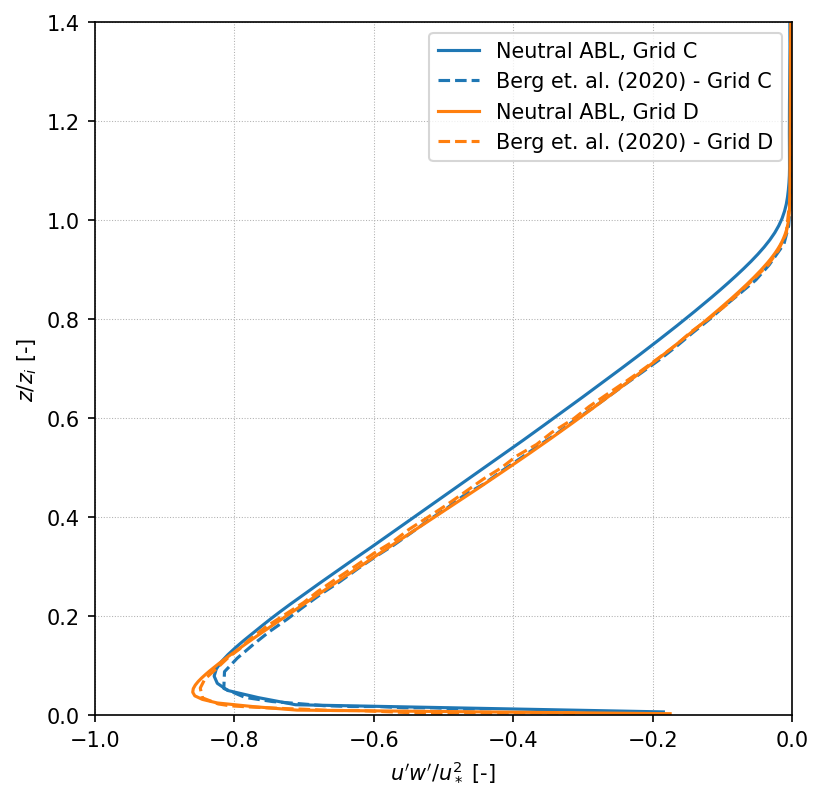

In [10]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
csvfiles = {}
csvfiles[casenames[0]] = ('../results/uw_C_berg.csv','Berg et. al. (2020) - Grid C')
csvfiles[casenames[1]] = ('../results/uw_D_berg.csv','Berg et. al. (2020) - Grid D')
var = 'ReStresses'
for case in casenames:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    uw = amrdat['uu uv uw vv vw ww']['data'][:,2]
    ustar = report['ustar']
    z = amrdat['uu uv uw vv vw ww']['z']
    lstyle=caseparams[case]['lstyle']
    plt.plot(uw/ustar**2, z/zi, label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color=lstyle['color'],ls='--',label=csvfiles[case][1])

ax.legend()
ax.set_xlim([-1.0, 0.0])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$u\'w\'/u_*^2$ [-]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')

Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r
Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r


Text(0, 0.5, '$z/z_i$ [-]')

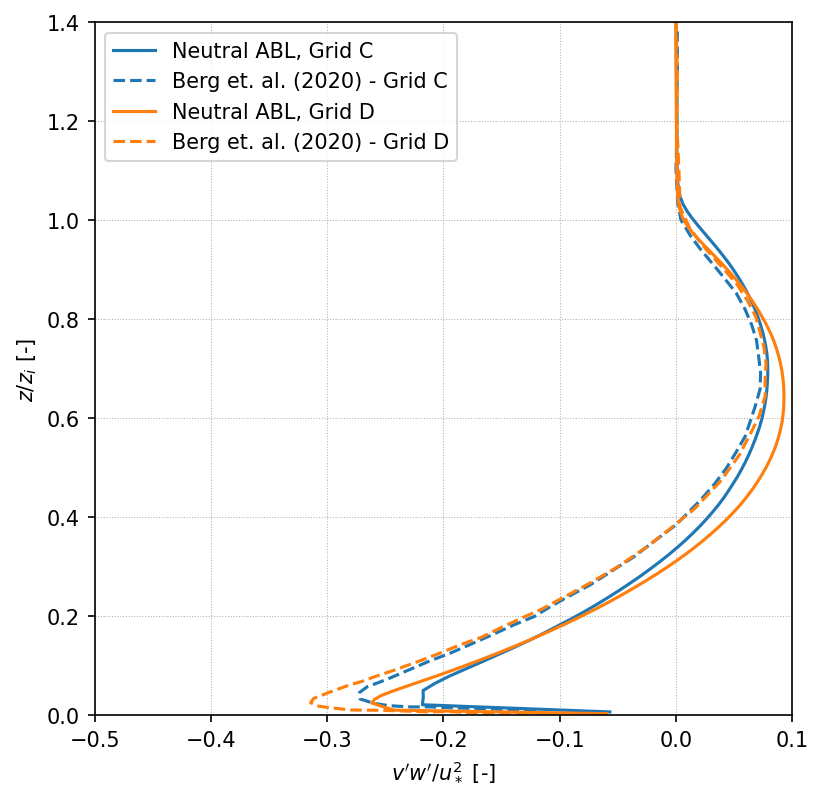

In [11]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
csvfiles = {}
csvfiles[casenames[0]] = ('../results/vw_C_berg.csv','Berg et. al. (2020) - Grid C')
csvfiles[casenames[1]] = ('../results/vw_D_berg.csv','Berg et. al. (2020) - Grid D')
var = 'ReStresses'
for case in casenames:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    uw = amrdat['uu uv uw vv vw ww']['data'][:,4]
    ustar = report['ustar']
    z = amrdat['uu uv uw vv vw ww']['z']
    lstyle=caseparams[case]['lstyle']
    plt.plot(uw/ustar**2, z/zi, label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color=lstyle['color'],ls='--',label=csvfiles[case][1])

ax.legend()
ax.set_xlim([-0.5, 0.1])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$v\'w\'/u_*^2$ [-]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')